This example is taken from ThinkBayes, I'll add different versions in the future.

Poisson process, a model used to describe events that occur at random intervals.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import empiricaldist as emd
import scipy.stats as st

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Game: France 4 - 2 Crotia

* How confident should we be that France is the better team?
* If the same teams played again, what is the chance France would win again?

To model, we'll make some assumptions:
* There is a goal scoring-rate (for any team), measured in goals per game, called lambda.
* A goal is equally likely during any minute of the game.
* A team never scores twice during the same minute.

These are not unreasonable assumptions.

In [2]:
lam = 1.4 # lambda, goal scoring rate (i.e. goals per game)
dist = st.poisson(lam)
type(dist)

scipy.stats._distn_infrastructure.rv_discrete_frozen

In [3]:
k = 4 # probability of scoring "k" goals (4 in this case)
dist.pmf(k) # pmf evaluated at 4.

0.039471954028253146

about 4%

In [4]:
lam = 1.4
qs = np.arange(10)
ps = st.poisson(lam).pmf(qs)

ps

array([2.46596964e-01, 3.45235750e-01, 2.41665025e-01, 1.12777012e-01,
       3.94719540e-02, 1.10521471e-02, 2.57883433e-03, 5.15766866e-04,
       9.02592015e-05, 1.40403202e-05])

Text(0, 0.5, 'PMF')

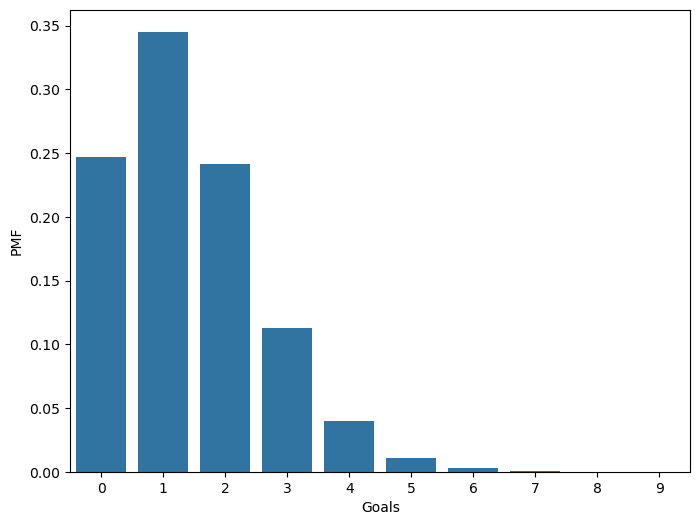

In [5]:
fig = plt.figure(figsize=(8,6))
g = sns.barplot(x=qs, y=ps)

g.set_xlabel('Goals')
g.set_ylabel('PMF')

When a good team plays against a bad one, lam should be higher; for a bad team against a good one, it should be lower.

Gamma distribution fits well to these types of situations:
* The goal scoring rate is continuous and non-negative.
* The gamma distribution has only one parameter, alpha, which is the mean (easy to construct)
* Shape of the gamma distribution makes sense taken what we know about soccer into account.

In [6]:
alpha = 1.4 # mean of the dist.
qs = np.linspace(0, 10, 101) # possible values of lam between 0 and 10
ps = st.gamma(alpha).pdf(qs) # probability densities

In [7]:
prior = emd.Pmf(ps, qs)
prior.normalize()

9.889360237140306

In [8]:
df_prior = pd.DataFrame(prior.ps, prior.qs).rename(columns={0:'probas'})
df_prior.head()

,probas
0.000,0.000
0.100,0.041
0.200,0.049
0.300,0.052
0.400,0.053


Text(0.5, 0, 'Quantities (goals)')

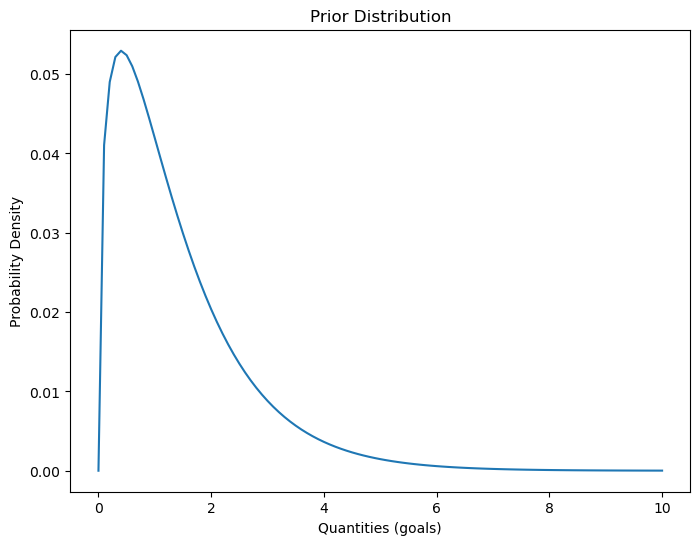

In [9]:
fig = plt.figure(figsize=(8,6))
g = sns.lineplot(x=df_prior.index, y=df_prior.probas)

g.set_title('Prior Distribution')
g.set_ylabel('Probability Density')
g.set_xlabel('Quantities (goals)')

In [10]:
np.sum(df_prior.index * df_prior.probas) # mean of the distribution

1.4140818156118378

### Updating with new data

In [11]:
lams = qs # different lambdas (different goal scoring rates)
k = 4 # observed data
likelihood = st.poisson(lams).pmf(k) # for each goal scoring rate, how likely we are to see 4 goals
likelihood[:4]

array([0.00000000e+00, 3.77015591e-06, 5.45820502e-05, 2.50026149e-04])

In [12]:
df_prior['likelihood'] = likelihood
df_prior.head()

,probas,likelihood
0.000,0.000,0.000
0.100,0.041,0.000
0.200,0.049,0.000
0.300,0.052,0.000
0.400,0.053,0.001


In [13]:
p_norm = emd.Pmf(df_prior['probas'] * df_prior['likelihood'], df_prior.index)
p_norm.normalize()

0.05015532557804499

In [14]:
df_prior['posterior'] = p_norm

Text(0.5, 1.0, 'France')

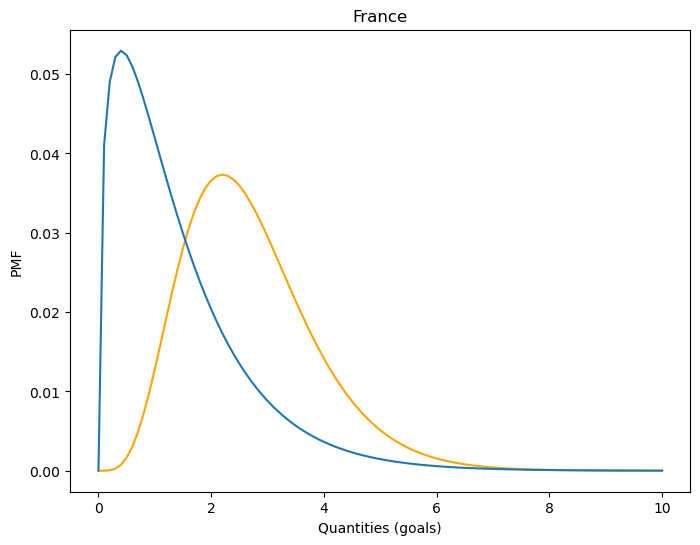

In [15]:
fig = plt.figure(figsize=(8,6))
g = sns.lineplot(x=df_prior.index, y=df_prior.posterior, color='orange')
g = sns.lineplot(x=df_prior.index, y=df_prior.probas)

g.set_xlabel('Quantities (goals)')
g.set_ylabel('PMF')
g.set_title('France')

In [16]:
df_crotia = df_prior[['probas']].copy()
df_crotia.head(3)

,probas
0.000,0.000
0.100,0.041
0.200,0.049


In [17]:
k = 2
likelihood_cro = st.poisson(lams).pmf(2)
likelihood_cro[:4]

array([0.        , 0.00452419, 0.01637462, 0.03333682])

In [18]:
df_crotia['likelihood'] = likelihood_cro

In [19]:
p_norm = emd.Pmf(df_crotia['probas'] * df_crotia['likelihood'], df_crotia.index)
p_norm.normalize()

0.1609321178598705

In [20]:
df_crotia['posterior'] = p_norm

Text(0.5, 1.0, 'Crotia')

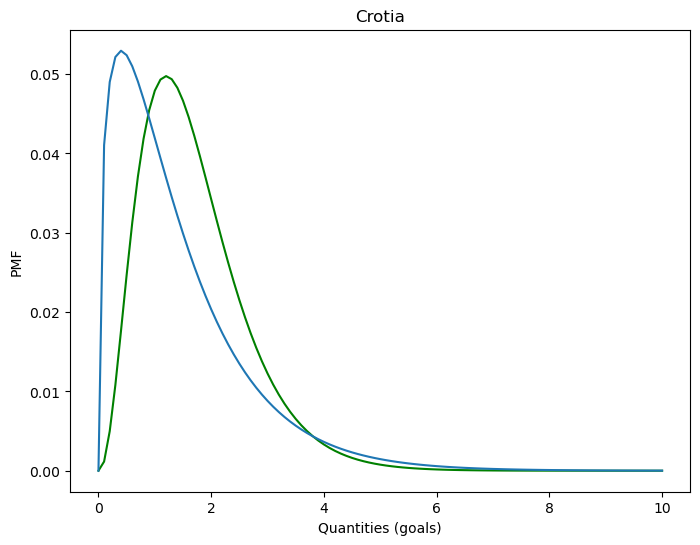

In [21]:
fig = plt.figure(figsize=(8,6))
g = sns.lineplot(x=df_crotia.index, y=df_crotia['posterior'], color='green')
g = sns.lineplot(x=df_crotia.index, y=df_crotia['probas'])

g.set_xlabel('Quantities (goals)')
g.set_ylabel('PMF')
g.set_title('Crotia')

If the same teams played again, what is the chance Crotia would win?

In [22]:
np.sum(df_prior.index * df_prior.posterior) # mean of France

2.699772393342308

In [23]:
np.sum(df_crotia.index * df_crotia.posterior) # mean of Crotia

1.6999765866755225

Text(0.5, 1.0, 'France vs Crotia (rematch)')

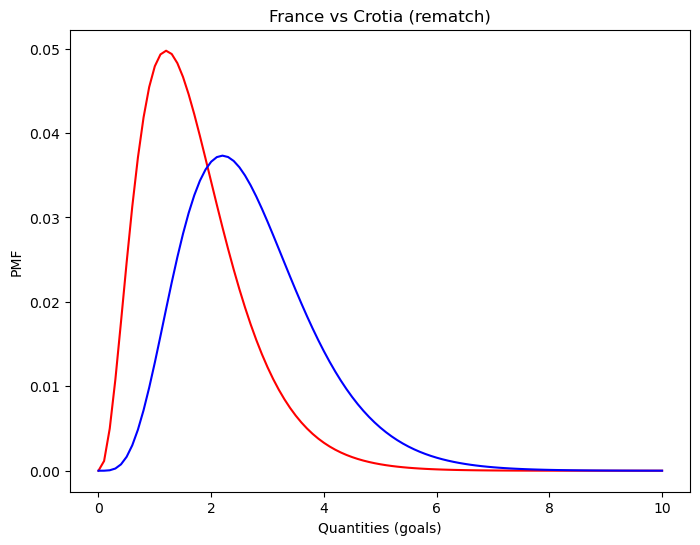

In [24]:
fig = plt.figure(figsize=(8,6))
g = sns.lineplot(x=df_crotia.index, y=df_crotia['posterior'], color='red')
g = sns.lineplot(x=df_prior.index, y=df_prior['posterior'], color='blue')

g.set_xlabel('Quantities (goals)')
g.set_ylabel('PMF')
g.set_title('France vs Crotia (rematch)')

In [25]:
# Probability of superiority.

france_prob = 0

for i in df_prior.index.tolist():
    for j in df_crotia.index.tolist():
        if i > j:
            france_prob += df_prior.loc[i, 'posterior'] * df_crotia.loc[j, 'posterior']
        else:
            continue

france_prob

0.7499366290930155

Probability of superiority is a way to represent an effect size actually. There is a really nice example on https://rpsychologist.com/cohend/